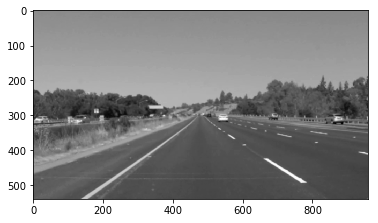

In [23]:
# Setup import the required library
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

# More setup, loading the image and grayscaling it.
# Pick an image. Any image.
# Or, in this case I picked solidYellowLeft because threshold yellow < white.
image = mpimg.imread('./test_images/solidYellowLeft.jpg')
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

# Define a kernel size and apply Gaussian smoothing to reduce noise
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

plt.imshow(blur_gray, cmap='gray')
plt.show()

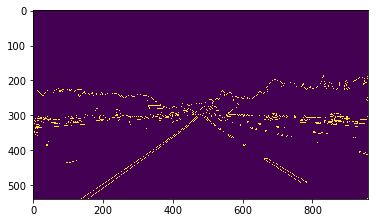

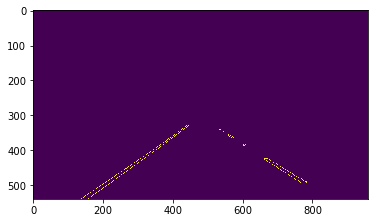

In [24]:
# Cannyfy to extract edges
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

plt.imshow(edges)
plt.show()

# Create a polygon mask to select region of interest
mask = np.zeros_like(edges)   
ignore_mask_color = 255   
imshape = image.shape
vertices = np.array([[(0,imshape[0]),(450, imshape[0]*0.6), (500, imshape[0]*0.6), (imshape[1],imshape[0])]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(edges, mask)

plt.imshow(masked_edges)
plt.show()

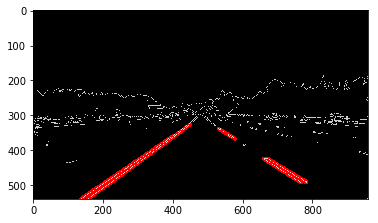

In [20]:
# Define the Hough transform parameters
# Then draw the lines on a new copy of the image.

# Hough parameters setup
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 40     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 20 #minimum number of pixels making up a line
max_line_gap = 20    # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

# Iterate over the output "lines" and draw lines on a blank image
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

# Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges)) 

# Draw the lines on the edge image
lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
plt.imshow(lines_edges)
plt.show()